In [1]:
# %%capture
# !pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import os

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
datasets = os.listdir("../FinalDatasets/")

In [4]:
tokenizer = BertTokenizer.from_pretrained('dkleczek/bert-base-polish-uncased-v1')
labels = {'neg':0, 'neu':1,'pos':2}

def readDataset(datasetName):
    datapath = f"../ProcessedDatasets/{datasetName}"
    df = pd.read_json(datapath, orient='records')
    df['label'].hist()
    plt.show()

    plt.hist([len(review.split(" ")) for review in df[df['label']=='neg']['text']], bins=20, density=True)
    plt.title("negative reviews length")
    plt.xlim([0, 150])
    plt.show()

    plt.hist([len(review.split(" ")) for review in df[df['label']=='pos']['text']], bins=20, density=True)
    plt.title("positive reviews length")
    plt.xlim([0, 150])
    plt.show()
    df.head()
    return df

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('dkleczek/bert-base-polish-uncased-v1')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
def evaluate_old(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

def predict(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    preds = np.array([])
    labels = np.array([])
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                preds = np.concatenate([preds, output.argmax(dim=1).cpu().numpy()])
                labels = np.concatenate([labels, test_label.cpu().numpy()])
    return preds, labels

def predictSingleExample(text, model):
    device = 'cuda'
    inv_labels = {v: k for k, v in labels.items()}
    predict_input = tokenizer(text, padding='max_length', max_length = 512, truncation=True,return_tensors="pt")

    mask = predict_input['attention_mask'].to(device)
    input_id = predict_input['input_ids'].to(device)

    output = model(input_id, mask)
    print(f"TXT: {text}\nLABEL:{inv_labels[output.argmax(dim=1).cpu().numpy()[0]]}")

def evaluate(model, df_test):
    preds, y_test = predict(model, df_test)
    accuracy = accuracy_score(preds, y_test)
    recall = recall_score(preds, y_test, average=None)
    cm = confusion_matrix(preds, y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','neu','pos'])
    f1 = f1_score(preds, y_test, average=None)
    disp.plot()

    return pd.DataFrame({'dataset':[dataset], 'accuracy':[np.round(accuracy, 3)], 'recall':[np.round(recall, 3)], 'f1_score':[np.round(f1,3)], 'training samples':[len(df_train)]})

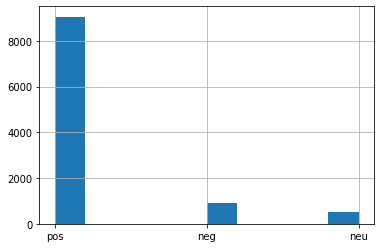

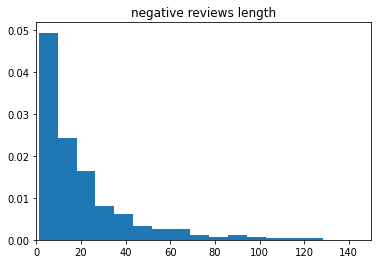

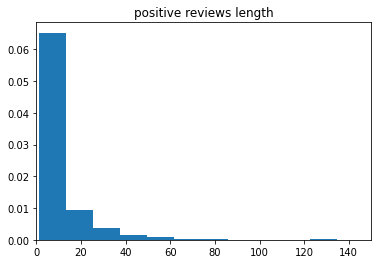

In [5]:
dataset = datasets[0]
np.random.seed(112)
df = readDataset(dataset)
df_train, df_val, df_test_ptm = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

In [6]:
results = pd.DataFrame(columns=['dataset', 'accuracy', 'recall', 'f1_score', 'training samples'])

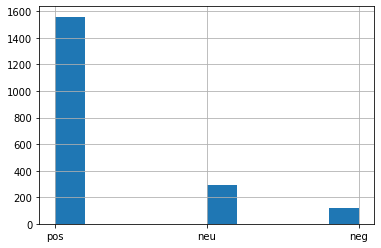

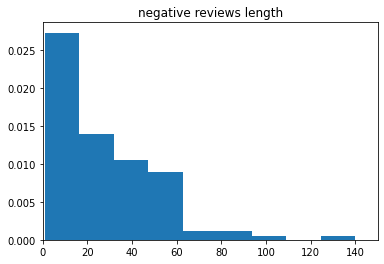

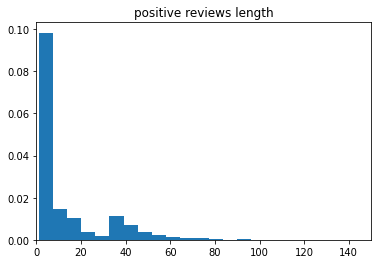

train:1571 val:196 test:1048


Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 786/786 [01:42<00:00,  7.66it/s]


Epochs: 1 | Train Loss:  0.380 | Train Accuracy:  0.643 | Val Loss:  0.240 | Val Accuracy:  0.832
---- negative ----
TXT: Po wcierce piecze mnie skóra głowy, a później występuje łupież.
LABEL:pos
TXT: Skuszona ceną kupiłam! Dziwię się komentarzom które tutaj się znajdują że super rewelacyjny produkt? Najgorsze jest w tym wszystkim to, że tabletki a w zasadzie ich drobne elementy pozostają na naczyniachW efekcie końcowym niebieskie, zielone plamy na talerzach, które trzeba drugi raz myć. Szkoda pieniędzy. Próbowałam wrzucać po dwie tabletki problem jednak leży w tym że pozostają zielone pozostałości tabletek na naczyniach . Nie polecam
LABEL:pos
TXT: może i to coś pierze, ale zapach to tragedia. chemiczny, okropny, mocny, nie da rady się go pozbyć po kolejnym praniu i przy 10 płukaniach. nawet namaczanie nie pomogło. drażni nos, poza tym płyn miał nie zawierać alergenów a ten "zapach" to jest jeden wielki alergen. a na butelce napis o dodatkowych innych środkach mogących wywoływać alerg

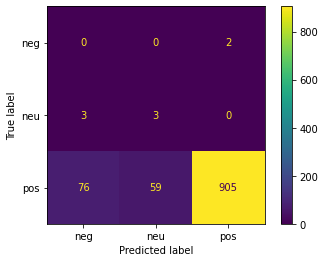

In [7]:
# data
dataset = datasets[1]
np.random.seed(112)
df = readDataset(dataset)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
df_test = df_test_ptm
print(f"train:{len(df_train)} val:{len(df_val)} test:{len(df_test)}")

#model
EPOCHS = 1
model = BertClassifier()
LR = 1e-6
batch_size = 2
train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), f"{dataset[:-5]}.pt")

# evaluation
evaluation = evaluate(model, df_test)
evaluation['epoch'] = EPOCHS
results = pd.concat([results, evaluation])

print("---- negative ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='neg'].reset_index()['text'][i], model)

print("---- positive ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='pos'].reset_index()['text'][i], model)

wykorzystanie modelu wyuczoonego na innych danych daje słabe efekty

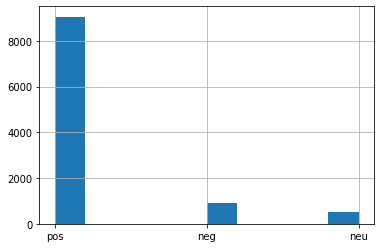

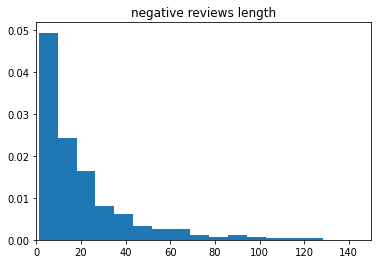

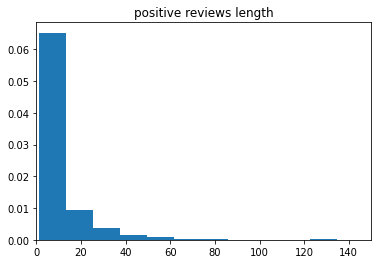

train:8380 val:1048 test:1048


Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4190/4190 [08:38<00:00,  8.07it/s]


Epochs: 1 | Train Loss:  0.164 | Train Accuracy:  0.870 | Val Loss:  0.103 | Val Accuracy:  0.930


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---- negative ----
TXT: Po wcierce piecze mnie skóra głowy, a później występuje łupież.
LABEL:neg
TXT: Skuszona ceną kupiłam! Dziwię się komentarzom które tutaj się znajdują że super rewelacyjny produkt? Najgorsze jest w tym wszystkim to, że tabletki a w zasadzie ich drobne elementy pozostają na naczyniachW efekcie końcowym niebieskie, zielone plamy na talerzach, które trzeba drugi raz myć. Szkoda pieniędzy. Próbowałam wrzucać po dwie tabletki problem jednak leży w tym że pozostają zielone pozostałości tabletek na naczyniach . Nie polecam
LABEL:neg
TXT: może i to coś pierze, ale zapach to tragedia. chemiczny, okropny, mocny, nie da rady się go pozbyć po kolejnym praniu i przy 10 płukaniach. nawet namaczanie nie pomogło. drażni nos, poza tym płyn miał nie zawierać alergenów a ten "zapach" to jest jeden wielki alergen. a na butelce napis o dodatkowych innych środkach mogących wywoływać alergie. nie polecam.
LABEL:neg
---- positive ----
TXT: Będę zadowolony !!!
LABEL:pos
TXT: Produkt bard

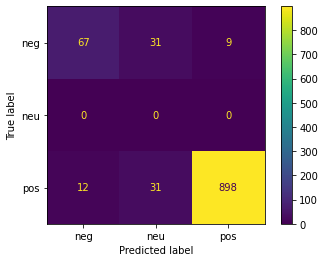

In [8]:
# data
dataset = datasets[0]
np.random.seed(112)
df = readDataset(dataset)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
df_test = df_test_ptm
print(f"train:{len(df_train)} val:{len(df_val)} test:{len(df_test)}")

#model
EPOCHS = 1
model = BertClassifier()
LR = 1e-6
batch_size = 2
train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), f"{dataset[:-5]}.pt")

# evaluation
evaluation = evaluate(model, df_test)
evaluation['epoch'] = EPOCHS
results = pd.concat([results, evaluation])

print("---- negative ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='neg'].reset_index()['text'][i], model)

print("---- positive ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='pos'].reset_index()['text'][i], model)

Uczenie modelu na danych dotyczących proszków do pranie, tabletek do zmywarki i kubków termicznych, daje lepsze efekty jako, ze chcemy klasyfikować opinie dotyczące tych kategoorii.

Teraz spróbuję poprawić model poprzez zbilansowanie zbioru danych uczących

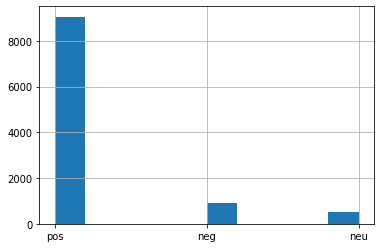

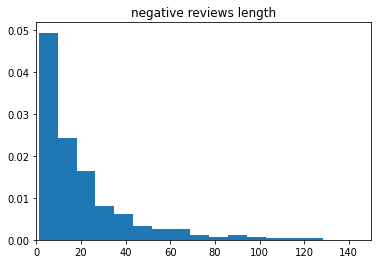

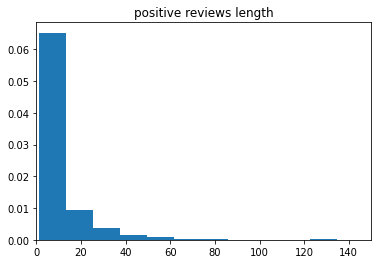

train:1221 val:1048 test:1048


Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 611/611 [01:15<00:00,  8.08it/s]


Epochs: 1 | Train Loss:  0.535 | Train Accuracy:  0.408 | Val Loss:  0.445 | Val Accuracy:  0.636
---- negative ----
TXT: Po wcierce piecze mnie skóra głowy, a później występuje łupież.
LABEL:neg
TXT: Skuszona ceną kupiłam! Dziwię się komentarzom które tutaj się znajdują że super rewelacyjny produkt? Najgorsze jest w tym wszystkim to, że tabletki a w zasadzie ich drobne elementy pozostają na naczyniachW efekcie końcowym niebieskie, zielone plamy na talerzach, które trzeba drugi raz myć. Szkoda pieniędzy. Próbowałam wrzucać po dwie tabletki problem jednak leży w tym że pozostają zielone pozostałości tabletek na naczyniach . Nie polecam
LABEL:neg
TXT: może i to coś pierze, ale zapach to tragedia. chemiczny, okropny, mocny, nie da rady się go pozbyć po kolejnym praniu i przy 10 płukaniach. nawet namaczanie nie pomogło. drażni nos, poza tym płyn miał nie zawierać alergenów a ten "zapach" to jest jeden wielki alergen. a na butelce napis o dodatkowych innych środkach mogących wywoływać alerg

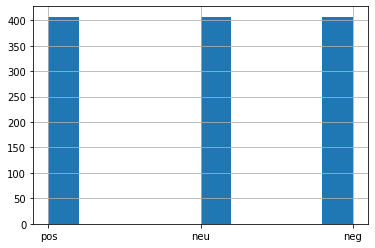

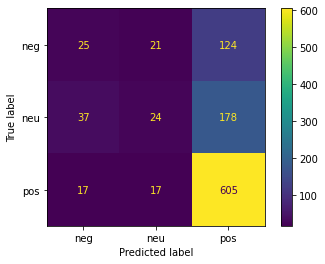

In [9]:
# data
dataset = datasets[0]
np.random.seed(112)
df = readDataset(dataset)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
categoryLen = len(df_train[df_train['label']=='neu'])
df_train_pos = df_train[df_train['label']=='pos'][:categoryLen]
df_train_neu = df_train[df_train['label']=='neu'][:categoryLen]
df_train_neg = df_train[df_train['label']=='neg'][:categoryLen]
df_train = pd.concat([df_train_pos, df_train_neu, df_train_neg])
df_train['label'].hist()

df_test = df_test_ptm
print(f"train:{len(df_train)} val:{len(df_val)} test:{len(df_test)}")

#model
EPOCHS = 1
model = BertClassifier()
LR = 1e-6
batch_size = 2
train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), f"{dataset[:-5]}.pt")

# evaluation
evaluation = evaluate(model, df_test)
evaluation['epoch'] = EPOCHS
results = pd.concat([results, evaluation])

print("---- negative ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='neg'].reset_index()['text'][i], model)

print("---- positive ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='pos'].reset_index()['text'][i], model)

In [10]:
evaluation

,dataset,accuracy,recall,f1_score,training samples,epoch
0,complete_dataset_ptm.json,0.624,"[0.147, 0.1, 0.947]","[0.201, 0.159, 0.783]",1221,1


Osiągnęliśmy lepszy wynik dla klasy neutralnej, ale dla pozostałych wynik jest gorszy

Teraz poeksperymentuję z ilością epok

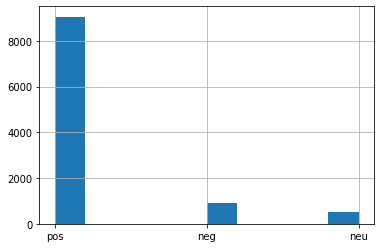

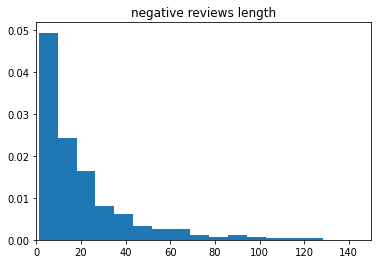

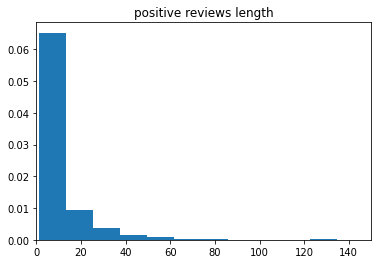

train:8380 val:1048 test:1048


Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4190/4190 [08:38<00:00,  8.09it/s]


Epochs: 1 | Train Loss:  0.168 | Train Accuracy:  0.879 | Val Loss:  0.107 | Val Accuracy:  0.927


100%|██████████| 4190/4190 [14:59<00:00,  4.66it/s]    


Epochs: 2 | Train Loss:  0.095 | Train Accuracy:  0.937 | Val Loss:  0.097 | Val Accuracy:  0.930


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---- negative ----
TXT: Po wcierce piecze mnie skóra głowy, a później występuje łupież.
LABEL:neg
TXT: Skuszona ceną kupiłam! Dziwię się komentarzom które tutaj się znajdują że super rewelacyjny produkt? Najgorsze jest w tym wszystkim to, że tabletki a w zasadzie ich drobne elementy pozostają na naczyniachW efekcie końcowym niebieskie, zielone plamy na talerzach, które trzeba drugi raz myć. Szkoda pieniędzy. Próbowałam wrzucać po dwie tabletki problem jednak leży w tym że pozostają zielone pozostałości tabletek na naczyniach . Nie polecam
LABEL:neg
TXT: może i to coś pierze, ale zapach to tragedia. chemiczny, okropny, mocny, nie da rady się go pozbyć po kolejnym praniu i przy 10 płukaniach. nawet namaczanie nie pomogło. drażni nos, poza tym płyn miał nie zawierać alergenów a ten "zapach" to jest jeden wielki alergen. a na butelce napis o dodatkowych innych środkach mogących wywoływać alergie. nie polecam.
LABEL:neg
---- positive ----
TXT: Będę zadowolony !!!
LABEL:pos
TXT: Produkt bard

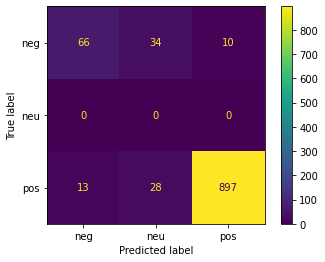

In [11]:
# data
dataset = datasets[0]
np.random.seed(112)
df = readDataset(dataset)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
df_test = df_test_ptm
print(f"train:{len(df_train)} val:{len(df_val)} test:{len(df_test)}")

#model
EPOCHS = 2
model = BertClassifier()
LR = 1e-6
batch_size = 2
train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), f"{dataset[:-5]}.pt")

# evaluation
evaluation = evaluate(model, df_test)
evaluation['epoch'] = EPOCHS
results = pd.concat([results, evaluation])

print("---- negative ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='neg'].reset_index()['text'][i], model)

print("---- positive ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='pos'].reset_index()['text'][i], model)

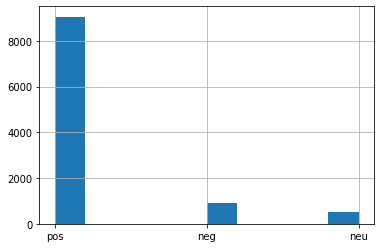

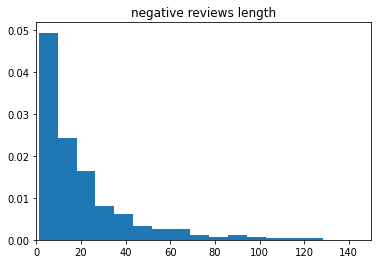

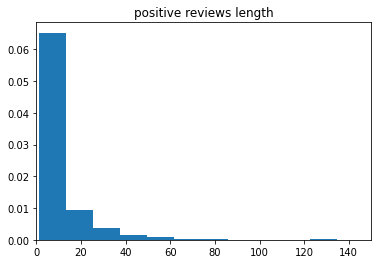

train:1221 val:1048 test:1048


Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 611/611 [01:16<00:00,  7.94it/s]


Epochs: 1 | Train Loss:  0.549 | Train Accuracy:  0.341 | Val Loss:  0.576 | Val Accuracy:  0.095


100%|██████████| 611/611 [01:14<00:00,  8.22it/s]


Epochs: 2 | Train Loss:  0.513 | Train Accuracy:  0.426 | Val Loss:  0.581 | Val Accuracy:  0.160
---- negative ----
TXT: Po wcierce piecze mnie skóra głowy, a później występuje łupież.
LABEL:neu
TXT: Skuszona ceną kupiłam! Dziwię się komentarzom które tutaj się znajdują że super rewelacyjny produkt? Najgorsze jest w tym wszystkim to, że tabletki a w zasadzie ich drobne elementy pozostają na naczyniachW efekcie końcowym niebieskie, zielone plamy na talerzach, które trzeba drugi raz myć. Szkoda pieniędzy. Próbowałam wrzucać po dwie tabletki problem jednak leży w tym że pozostają zielone pozostałości tabletek na naczyniach . Nie polecam
LABEL:neg
TXT: może i to coś pierze, ale zapach to tragedia. chemiczny, okropny, mocny, nie da rady się go pozbyć po kolejnym praniu i przy 10 płukaniach. nawet namaczanie nie pomogło. drażni nos, poza tym płyn miał nie zawierać alergenów a ten "zapach" to jest jeden wielki alergen. a na butelce napis o dodatkowych innych środkach mogących wywoływać alerg

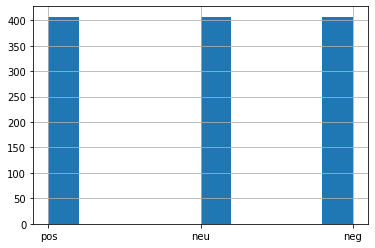

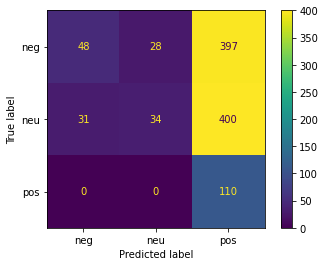

In [12]:
# data
dataset = datasets[0]
np.random.seed(112)
df = readDataset(dataset)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
categoryLen = len(df_train[df_train['label']=='neu'])
df_train_pos = df_train[df_train['label']=='pos'][:categoryLen]
df_train_neu = df_train[df_train['label']=='neu'][:categoryLen]
df_train_neg = df_train[df_train['label']=='neg'][:categoryLen]
df_train = pd.concat([df_train_pos, df_train_neu, df_train_neg])
df_train['label'].hist()

df_test = df_test_ptm
print(f"train:{len(df_train)} val:{len(df_val)} test:{len(df_test)}")

#model
EPOCHS = 2
model = BertClassifier()
LR = 1e-6
batch_size = 2
train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), f"{dataset[:-5]}.pt")

# evaluation
evaluation = evaluate(model, df_test)
evaluation['epoch'] = EPOCHS
results = pd.concat([results, evaluation])

print("---- negative ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='neg'].reset_index()['text'][i], model)

print("---- positive ----")
for i in range(3):
    predictSingleExample(df_test[df_test['label']=='pos'].reset_index()['text'][i], model)

In [15]:
# results.to_csv("results.csv", sep=";", index=False)

# Podsumowanie
Danych jest dosyć mało. Nie istnieje wystarczająco dużo opini w internecie na temat tylko proszków do prania, tabletek doo zmywarki i kubków termicznych. Ponadto niezbilansowany zbiór danych utrudnia zadanie. Pokazaliśmy, że da się stworzyć model, który dobrze odróżna opinie pozyttywne i negatywne, ucząc się nawet na stosunkowo małym zbiorze danych, jednakże mała liczba przykładów neutralnych oraz fakt tego, że komentarz neutralny równie dobrze mógłby być pozytywny lub negatywny (labele dla tek klasy wydają się być mocno zaszumione). Powoduje, że klasyfikowanie opinii neutralnych jest bardzo trudne. Uważam, że wytrenowaliśmy dwa sensowne modele. Jeden pozwala bardzo dobrze odróżniać opinie pozytywne i negatywne. To jest model wytrenowany na wszystkich danych o proszkach kubkach itd. oraz model który wytrenowaliśmy na zbilansowanym zbiorze danych. Model ten lepiej generalizuje. Jeżeli chodzi o metrtyki jest gordzy ale byle jak, ale wykrywa klasę neutralną. Przy trenowaniu przez 2 epoki dało się zauważyć overfitting. Przy trenowaniu przez 2 eopoki metryki się pogarszały.